In [1]:
import gym
from ale_py import ALEInterface
import ale_py
from ale_py.roms import MsPacman
import time
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm as tqdm

In [2]:
ale = ALEInterface()
ale.loadROM(MsPacman)

In [3]:
#env = gym.make('ALE/MsPacman-v5')
# ale-import-roms
env = gym.make('ALE/MsPacman-ram-v5')

In [4]:
env.reset()
observations, reward, done, infos = env.step(0)

The Atari 2600 hardware was based on the MOS Technology 6507 chip, offering 128 bytes of RAM

In [5]:
observations.shape

(128,)

In [6]:
env.action_space

Discrete(18)

# How many neurons This NN must have?

The number of hidden neurons should be between the size of the input layer and the size of the output layer.

In [7]:
print(f'Between {128} and 18')

Between 128 and 18


The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.

In [8]:
print(f'Should be {np.ceil(128 * (2/3) + 18)} Neurons')

Should be 104.0 Neurons


The number of hidden neurons should be less than twice the size of the input layer.

In [9]:
print(f'Should be less than {2 * 128}')

Should be less than 256


In [10]:
observations

array([  0, 112, 114, 115,   0,   3,  88,  88,  88,  88,  88,   0,  80,
        80,  80,  50,  98,   0,   0,   3,   0,   0,   1,   0,   0,   1,
         6,   6, 198,   4,  76,   0,  45,   1,   0, 198, 198,   0,   0,
         1,   0,  32,  52,   0,   0, 120,   0, 100, 130,   0,   0, 134,
         1, 222,   0,   1,   3,   0,   6,  80, 255, 255,   0, 255, 255,
        80, 255, 255,  80, 255, 255,  80, 255, 255,  80, 191, 191,  80,
       191, 191,  80, 191, 191,  80, 255, 255,  80, 255, 255,  80, 255,
       255,  80, 255, 255,   0, 255, 255,  80, 255, 255,  20, 223,  43,
       217, 123, 217, 123, 217, 123, 217, 123, 217, 123, 217, 221,   0,
        63,   0,   0,   0,   0,   0,   2,  66, 240, 146, 215], dtype=uint8)

In [11]:
def softmax_activate(layer):
    m = np.exp(layer)
    return m / m.sum()

def sigmoid_activate(layer):
    return 1 / (1 + np.exp(-layer))

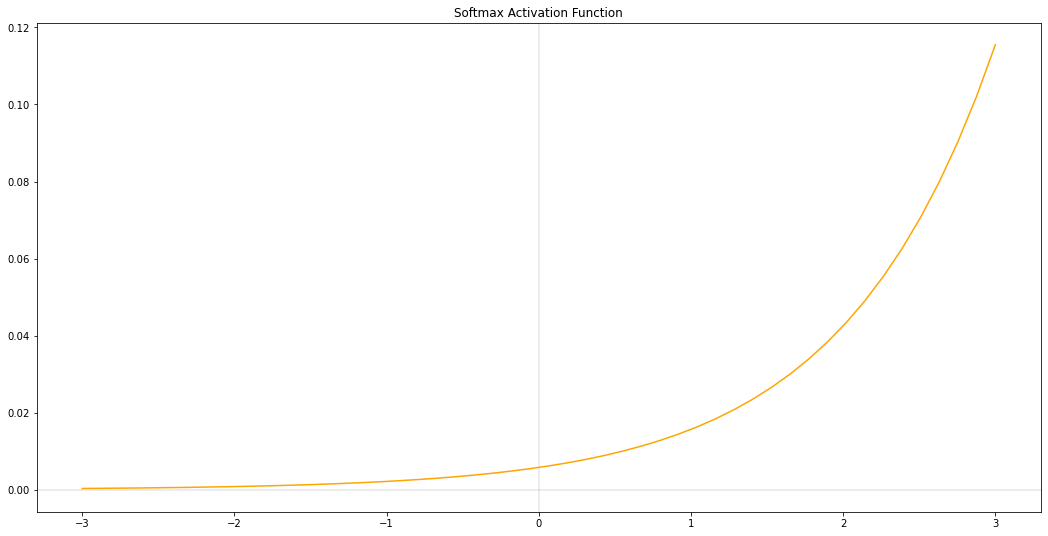

In [12]:
x = np.linspace(-3,3)
y = softmax_activate(x)

plt.figure(figsize=(18,9))
plt.axvline(0, color = 'gray', alpha = 0.2)
plt.axhline(0, color = 'gray', alpha = 0.2)
space = np.arange(-3, 3, 0.02)
activated = softmax_activate(space)
#plt.plot(x, x, color = 'blue')
plt.plot(x, y, color = 'orange')
plt.title('Softmax Activation Function');

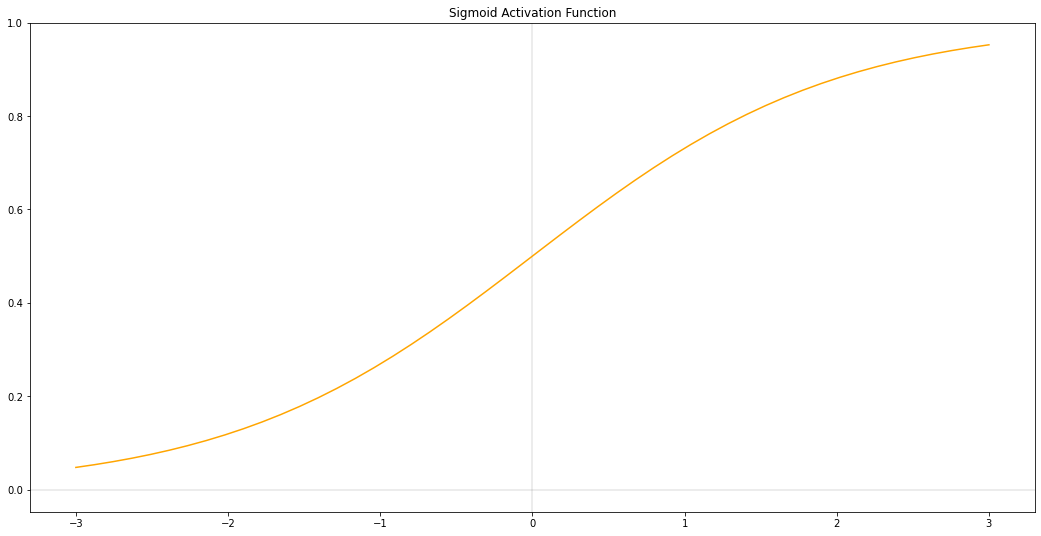

In [13]:
x = np.linspace(-3,3)
y = sigmoid_activate(x)

plt.figure(figsize=(18,9))
plt.axvline(0, color = 'gray', alpha = 0.2)
plt.axhline(0, color = 'gray', alpha = 0.2)
space = np.arange(-3, 3, 0.02)
activated = sigmoid_activate(space)
#plt.plot(x, x, color = 'blue')
plt.plot(x, y, color = 'orange')
plt.title('Sigmoid Activation Function');

In [14]:
nb_layers = 4
neurons = 256

In [15]:
percentage_saved = 0.15
chances_of_mutation = 2e-2

In [16]:
class NeuralNetwork:
    def __init__(self, observation_size, isACopy = False):
        self._rewards = 0
        #self._layers = np.array([], dtype=np.float128)
        #self._biases = np.array([], dtype=np.float128)
        
        self._layers = []
        self._biases = []
        
        if not isACopy:
            for i in range(nb_layers):
                entry_size = neurons if i != 0 else observation_size

                self._layers.append(np.random.rand(neurons, entry_size)*2 -1) #random.rand -> [0, 1] * 2 -> [0, 2] - 1 -> [-1, 1]
                self._biases.append(np.random.rand(neurons, 1)*2 -1)

            self._outputs = np.random.rand(18, neurons)*2 -1

    def forward(self, inputs):
        inputs = inputs.reshape((-1,1))

        #propagating trought the layers
        
        for layer, bias in zip(self._layers, self._biases):
            inputs = np.matmul(layer, inputs)
            inputs = inputs + bias
            inputs = sigmoid_activate(inputs)

        inputs = np.matmul(self._outputs, inputs)
        inputs = inputs.reshape(-1)

        return(softmax_activate(inputs))
    
    def mutate(self):
        new_pac = NeuralNetwork(self._layers[0].shape[1], isACopy=True)

        for l in self._layers:
            random_mutation_probs = np.random.rand(l.shape[0], l.shape[1])
            random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation, np.random.rand()-0.5/2, 0)

            new_layer = l + random_mutation_probs
            new_pac._layers.append(new_layer)

        for b in self._biases:
            random_mutation_probs = np.random.rand(b.shape[0], 1)
            random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation, np.random.rand()-0.5/2, 0)

            new_bias = b + random_mutation_probs
            new_pac._biases.append(new_bias)

        random_mutation_probs = np.random.rand(self._outputs.shape[0], self._outputs.shape[1])
        random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation, np.random.rand()-0.5/2, 0)

        new_layer = self._outputs + random_mutation_probs
        new_pac._outputs = self._outputs + random_mutation_probs

        return new_pac

    def set_reward(self, r):
        self._reward = r

In [17]:
obs_size = env.observation_space.shape[0]

Sample = NeuralNetwork(obs_size)

obs = env.reset().reshape(-1)

choice = Sample.forward(obs)

print('List of decisions:', choice)
print('Decision Taken:', choice.argmax())

List of decisions: [9.79953628e-07 3.25191188e-07 5.31956746e-11 3.48597323e-10
 1.60138815e-09 2.67298212e-04 6.45427748e-09 9.82911976e-01
 2.71778205e-08 6.31385017e-04 8.21820119e-05 4.10111038e-06
 1.36711882e-08 2.94901944e-07 1.50316855e-05 7.57979045e-09
 1.08342830e-04 1.59780262e-02]
Decision Taken: 7


C:\Users\Felipe\AppData\Local\Temp/ipykernel_3428/1628994785.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-layer))


In [18]:
number_of_pacs = 50

In [19]:
farm = []

for _ in range(number_of_pacs):
    P = NeuralNetwork(obs_size)
    farm.append(P)

In [20]:
def run_simulation(pac, nb_simulations = 10):
    total_reward = 0

    for _ in range(nb_simulations):
        observation = env.reset()
        done = False
        
        while(not done):
            observation, reward, done, infos, = env.step(pac.forward(observation).argmax())
            total_reward += reward

    pac.set_reward(total_reward)

    return total_reward

In [21]:
'''
rewards = []
for P in tqdm(farm):
    rewards.append(run_simulation(P))
'''

'\nrewards = []\nfor P in tqdm(farm):\n    rewards.append(run_simulation(P))\n'

In [22]:
'''
plt.figure(figsize=(16, 8))
plt.hist(rewards, 200);
'''

'\nplt.figure(figsize=(16, 8))\nplt.hist(rewards, 200);\n'

In [21]:
def restart_simulation():
    global farm
    for p in farm:
        del(p)
    
    farm = []

    for _ in range(number_of_pacs):
        P = NeuralNetwork(obs_size)
        farm.append(P)

In [22]:
def run_global_simulation(display_tqdm = True, display_graph = True, track_best = True):
    global farm

    rewards = []

    if display_tqdm:
        for P in tqdm(farm):
            rewards.append(run_simulation(P))
    else:
        for P in farm:
            rewards.append(run_simulation(P))

    if display_graph:
        plt.figure(figsize=(16,8))
        plt.hist(rewards, bins=200)
        plt.show();

    farm.sort(key= lambda pac: pac._reward, reverse=True)

    if(track_best):
        print('Best reward this time : ' + str(farm[0]._reward))

    return farm[0]._reward

In [23]:
restart_simulation()

In [26]:
#run_global_simulation()

In [24]:
def darwin_cleaner():
    global farm

    qte_to_keep = int(percentage_saved * len(farm))
    new_farm = farm[:qte_to_keep]

    new_species = []
    
    for i in range(len(farm) - qte_to_keep):
        father_pac = new_farm[i%qte_to_keep]
        new_pac = father_pac.mutate()
        new_species.append(new_pac)
    
    farm = new_farm + new_species

In [25]:
darwin_cleaner()

In [29]:
'''
restart_simulation()
rewards = []
for _ in tqdm(range(15)):
    #rewards.append(run_global_simulation(False, False))
    x = run_global_simulation(False, False)
    rewards.append(x)
    darwin_cleaner()
    if x == 50000.0: break
plt.figure(figsize=(16,8))
plt.plot(rewards)

'''


'\nrestart_simulation()\nrewards = []\nfor _ in tqdm(range(15)):\n    #rewards.append(run_global_simulation(False, False))\n    x = run_global_simulation(False, False)\n    rewards.append(x)\n    darwin_cleaner()\n    if x == 50000.0: break\nplt.figure(figsize=(16,8))\nplt.plot(rewards)\n\n'

In [30]:
'''
def run_big_brain():

    observation = env.reset()
    env.render()

    time.sleep(2)

    done = False

    rewards = 0
    while not done:
        observation, reward, done, infos, = env.step(farm[0].forward(observation).argmax())
        env.render()
        time.sleep(0.05)
        rewards = rewards + reward
        print(rewards)

    env.close()
'''

'\ndef run_big_brain():\n\n    observation = env.reset()\n    env.render()\n\n    time.sleep(2)\n\n    done = False\n\n    rewards = 0\n    while not done:\n        observation, reward, done, infos, = env.step(farm[0].forward(observation).argmax())\n        env.render()\n        time.sleep(0.05)\n        rewards = rewards + reward\n        print(rewards)\n\n    env.close()\n'

In [31]:
#run_big_brain()

In [26]:
from joblib import Parallel, delayed
import multiprocessing #Required for computation.

num_cores = multiprocessing.cpu_count()

In [27]:
def run_simulation_parallel(pac, nb_of_simulations=10):
    
    total_reward = 0 #Used to track the performance
    local_env = gym.make('ALE/MsPacman-ram-v5')
    for _ in range(nb_of_simulations):
        
        observation = local_env.reset()
        done = False
        
        while(not done):
            observation, reward, done, info = local_env.step(pac.forward(observation).argmax()) #We exectue an action.
            #env.render() #We DO NOT CALL RENDER HERE, we now need speed!
            total_reward += reward
    
    pac.set_reward(total_reward)
    
    return pac

def run_global_simulation_parallel(display_tqdm = True, track_best = True, nb_of_simulations = 10): #We create a function which gives a run.
    global farm
    
    rewards = []
    
    if(display_tqdm):
        farm = Parallel(n_jobs=num_cores)(delayed(run_simulation_parallel)(S, nb_of_simulations) for S in tqdm(farm))
    else:
        farm = Parallel(n_jobs=num_cores)(delayed(run_simulation_parallel)(S, nb_of_simulations) for S in farm)
    
    
    farm.sort(key=lambda pac: pac._reward, reverse=True) #We order our list based on reward.
    
    if(track_best):
        print("Best reward this time "+str(farm[0]._reward)+" ; worst was "+str(farm[-1]._reward))

In [28]:
number_of_pacs = 20

In [29]:
restart_simulation()

In [36]:
#run_global_simulation_parallel(True, True)

In [30]:
import pickle #used to store the different generations

#We create function to compare our pacs.
def save_pac(id_iteration):
    with open("pac_{}.obj".format(id_iteration),'wb') as file_save:
        #We create a dict of the pac parameters
        to_save = {"layers":farm[0]._layers,
                     "biases":farm[0]._biases,
                     "outputs":farm[0]._outputs}
        #And save it using picke
        pickle.dump(to_save,file_save, protocol=pickle.HIGHEST_PROTOCOL)

def load_pac(id_iteration):
    with open("pac_{}.obj".format(id_iteration),'rb') as file_save:
        
        pac_params = pickle.load(file_save)

        pac = NeuralNetwork(obs_size)
        pac._layers = pac_params["layers"]
        pac._biases = pac_params["biases"]
        pac._outputs = pac_params["outputs"]
        
        return pac

In [31]:
#%matplotlib notebook

def interactive_plot():
    ax.set_ylim(min(generation_results)-1,max(generation_results)+1)
    ax.set_xlim(-1,len(generation_results)+1)
    x = np.arange(len(generation_results))
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(generation_results)
    else:
        ax.plot(x, generation_results)
    fig.canvas.draw()

  0%|          | 0/10 [00:00<?, ?generation/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 9440.0 ; worst was 600.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 11770.0 ; worst was 2100.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 6490.0 ; worst was 2100.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 5750.0 ; worst was 3650.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 8950.0 ; worst was 700.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 13000.0 ; worst was 700.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 11550.0 ; worst was 700.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 13300.0 ; worst was 700.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 11550.0 ; worst was 700.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best reward this time 11850.0 ; worst was 700.0


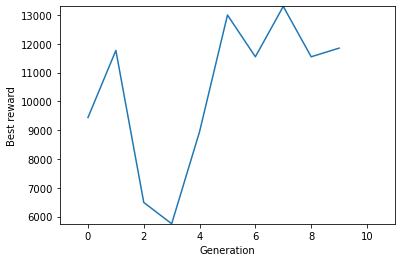

In [32]:

fig,ax = plt.subplots(1,1)
ax.set_xlabel('Generation')
ax.set_ylabel('Best reward')


generation_results = [] #Will be used to track the best element at each step.

number_of_pacs = 10
restart_simulation()


for iteration in tqdm(range(10),unit="generation"):
    run_global_simulation_parallel(True, True, nb_of_simulations=10)
        #We increase the number of simulation to get more data for each pac.
    generation_results.append(farm[0]._reward)
    interactive_plot()
    if(iteration % 10 == 0):
        save_pac(iteration)
    darwin_cleaner()

In [33]:
print("Best reward:"+str(farm[0]._reward))

Best reward:11850.0


In [34]:
print("Success:"+str((100-farm[0]._reward)/2+farm[0]._reward)+"%")

Success:5975.0%


In [35]:
for _ in tqdm(range(1)):
    observation = env.reset()
    done = False

    while(not done):
        env.render()
        done = False
        while(not done):
            observation, res, done, info = env.step(farm[0].forward(observation).argmax())
            env.render()
            time.sleep(0.1)
env.close()

  0%|          | 0/1 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\gym\envs\atari\environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Não é possível alterar o modo de thread depois de o mesmo estar definido
  warnings.warn(str(err))
C:\Users\Felipe\AppData\Local\Temp/ipykernel_3428/1628994785.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-layer))


In [46]:
big_brain = load_pac('0')

In [47]:
big_brain

In [48]:
for _ in tqdm(range(1)):
    observation = env.reset()
    done = False

    while(not done):
        env.render()
        done = False
        while(not done):
            observation, res, done, info = env.step(big_brain.forward(observation).argmax())
            env.render()
            time.sleep(0.1)
env.close()

  0%|          | 0/1 [00:00<?, ?it/s]